# Initialize

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from classy_sz import Class
import classy_sz
classy_sz.__file__

'/Users/boris/opt/miniconda3/lib/python3.9/site-packages/classy_sz-2.9.4-py3.9-macosx-11.0-arm64.egg/classy_sz.cpython-39-darwin.so'

In [135]:
#plotting settings
plot_params= {
    'figure.figsize': (8,6),
    'axes.labelsize': 15,
    'axes.grid': True,
    'grid.alpha': 0.2,
    'grid.linestyle':'--',
    'axes.grid.which': 'both',
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 13,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.major.size': 7,
    'xtick.minor.size': 3,
    'ytick.major.size': 7,
    'ytick.minor.size': 3,
    'axes.titlesize': 20,
    'xtick.major.size':5,
    'ytick.major.size':5,
    'xtick.major.pad':10,
    'ytick.major.pad':5,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    
}
plt.rcParams.update(plot_params)

In [136]:
# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf) Table 2
# TT,TE,EE+lowE+lensing+BAO
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,

'k_pivot': 0.05,
'N_ncdm': 1,
'N_ur': 2.0328,
'm_ncdm': 0.06}

In [137]:
zmin=0.0
zmax=15.
param_dict={
    'output':'mPk,dndlnM',
    'non_linear': 'hmcode',
    'z_min':zmin,
    'z_max':zmax,
    'z_max_pk':15.,
       }

In [138]:
%%time
M = Class()
M.set(cosmo_params)
M.set(param_dict)
M.compute()
kappa_kernel = np.vectorize(M.get_dkappacmbdz_at_l_and_z)
pknl = np.vectorize(M.get_pk_nonlin_at_k_and_z)

CPU times: user 12.5 s, sys: 34.2 ms, total: 12.6 s
Wall time: 1.88 s


In [139]:
kappa_kernel(10.,10)

array(3.60291517e-10)

In [140]:
pknl(1e10,0.)

array(0.)

# lensing kernel

In [145]:
%%time
z_array_2d = np.linspace(0.01,5,500)
l = np.linspace(2,100,500)
kappa_2d = np.zeros((500,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        kappa_2d[izp][ilq] = kappa_kernel(lm,zp)
        ilq+=1
    izp+=1

CPU times: user 2.17 s, sys: 5.58 ms, total: 2.17 s
Wall time: 2.17 s


In [146]:
kappa_2d.min()

5.409430361055257e-10

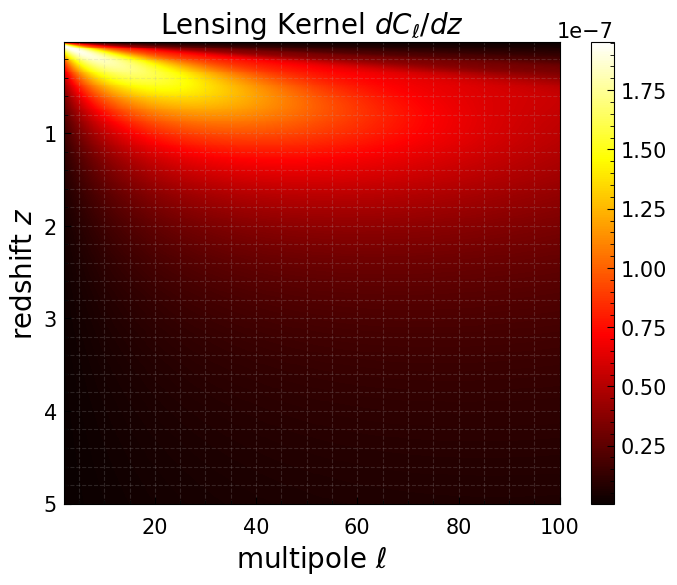

In [147]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2d, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('multipole $\ell$',size=20)
plt.ylabel('redshift $z$',size=20)
# plt.show()
plt.title('Lensing Kernel $dC_\ell/dz$')
plt.savefig('figures/kappa_kernel_heatmap.pdf')

# lensing kernel W(z)

In [148]:
M.angular_distance(1e-4)

0.4429869971248203

In [152]:
%%time
z_array_2d = np.linspace(0.01,15,500)
l = np.linspace(2,100,500)
kappa_2d = np.zeros((500,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        chi = M.angular_distance(zp)*(1+zp)*M.h()
        kl = (lm+0.5)/chi
        kappa_2d[izp][ilq] = kappa_kernel(lm,zp)/pknl(kl,zp)#/M.get_volume_dVdzdOmega_at_z(zp)
        ilq+=1
    izp+=1

CPU times: user 4.21 s, sys: 7.51 ms, total: 4.22 s
Wall time: 4.22 s


In [153]:
kappa_2d.min()

3.529750519592362e-12

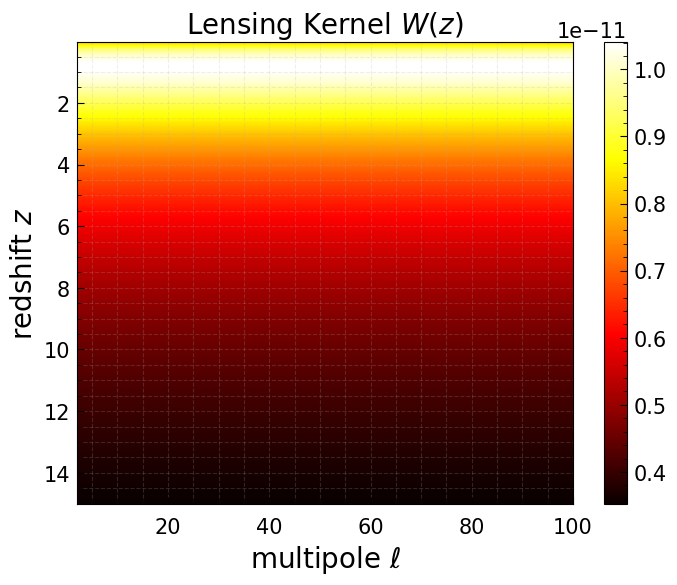

In [154]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2d, cmap='hot', 
                interpolation='nearest',
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('multipole $\ell$',size=20)
plt.ylabel('redshift $z$',size=20)
# plt.show()
plt.title('Lensing Kernel $W(z)$')
plt.savefig('figures/kappa_kernel_Wz_heatmap.pdf')